# SageMaker Processing Jobs - OpenGL Synthetic data generation
## NoGPU

**SageMaker Studio Kernel: Data Science**

In this exercise you'll learn how to create a custom Docker container capable of running OpenGL applications that require an X Server to render images. Then, using this container you'll be able to run an OpenGL application and export each frame to a new image. To save space and reduce the number of images to upload to S3 later, we'll create mosaics of .jpeg files that can later be loaded by your ML training code.

### 1) SageMaker Studio dependencies
if you're not using SageMaker Studio, you can ignore this step and build the container manually. But remember to create an ECR repo and push the image. SageMaker depends on ECR

In [ ]:
# https://github.com/aws-samples/sagemaker-studio-image-build-cli
%pip install sagemaker-studio-image-build

### 2) Create the Dockerfile

In [ ]:
import os
if not os.path.isdir('container_cpu'): os.mkdir('container_cpu')
if not os.path.isdir('src'): os.mkdir('src')

In [ ]:
%%writefile container_cpu/Dockerfile
FROM nvcr.io/nvidia/cudagl:11.2.2-runtime-ubuntu20.04

ARG DEBIAN_FRONTEND=noninteractive

ENV TZ UTC
ENV LANG=C.UTF-8
ENV LC_ALL=C.UTF-8
ENV PYTHONDONTWRITEBYTECODE=1
ENV PYTHONUNBUFFERED=1
ENV PYTHONIOENCODING=UTF-8

# Install Xorg and others
RUN apt update && apt install -y \
    build-essential ca-certificates \
    kmod libc6 libc6-dev curl file wget \
    bzip2 gzip zip unzip zstd git xvfb \
    python3 python3-opencv python3-opengl python3-pip python3-numpy \
    mesa-utils libglu1 libsm6 libxv1 libxtst6 freeglut3-dev \
    && rm -rf /var/lib/apt/lists/*

# If you need additional packages uncomment the following lines
#RUN apt update && apt install -y \
#    <<YOUR PACKAGES HERE>>
#    && rm -rf /var/lib/apt/lists/*

RUN echo "#!/bin/sh\n/usr/bin/xvfb-run -a \$@\n" > entrypoint.sh && chmod +x entrypoint.sh

ENTRYPOINT [ "/entrypoint.sh"]

### 3) Build the container image on Studio
If you're not using studio, use **docker build** to create the image. This library also creates an ECR repo if needed, and pushes the image to that repo. If you're building the image manually, you need to create an ECR repo first and then push the image before moving forward.

In [ ]:
image_name='sm-processing-opengl-cpu'

In [ ]:
!sm-docker build container_cpu/ --repository $image_name:latest

### 4) Check the sample OpenGL application
This is a Python app that will be executed inside the container. It renders a cube that can be rotated/translated to change the perspective. You can replace it by any other application to generate useful data.

In [ ]:
!pygmentize src/cube.py

### 5) Kick-off the processing job

In [ ]:
import sagemaker
import boto3
from sagemaker.processing import ScriptProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

sagemaker_session = sagemaker.Session()

account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = sagemaker_session.boto_session.region_name
bucket = sagemaker_session.default_bucket()

print(f"Bucket: {bucket}\nAWS AccountID: {account_id}\nRegion: {region_name}")

In [ ]:
import time
script_processor = ScriptProcessor(
    base_job_name=f'cube-opengl-{int(time.time()*1000)}',
    image_uri=f'{account_id}.dkr.ecr.{region_name}.amazonaws.com/{image_name}:latest',
    role=sagemaker.get_execution_role(),
    instance_type='ml.c5.xlarge',
    instance_count=1,
    max_runtime_in_seconds=60 * 30,
    command=["/entrypoint.sh", "python3"]
)

script_processor.run(
    code='src/cube.py',
    outputs=[
        ProcessingOutput(
            output_name='gen_images', 
            s3_upload_mode='Continuous', 
            destination=f"s3://{bucket}/cube-opengl-cpu/images",
            source='/opt/ml/processing/output'
        )
    ],
    arguments=[ #total of images = num-mosaics * (mosaic-tiles ** 2)
        '--num-mosaics', '100',
        '--mosaic-tiles', '20',
        '--image-size', '400'
    ]
)

### 6) Visualize a mosaic

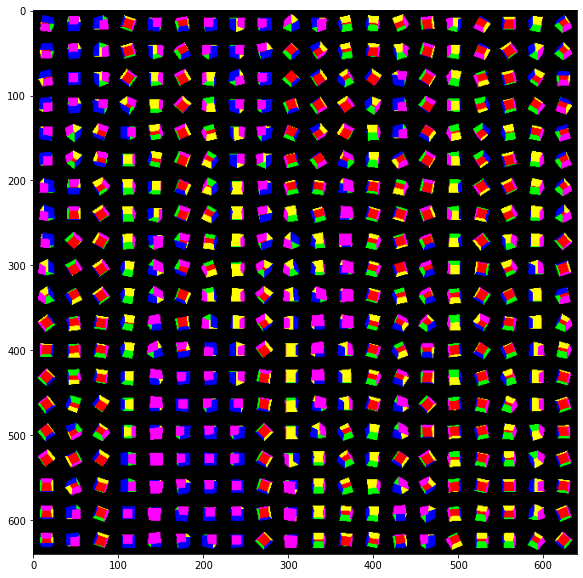

In [5]:
%matplotlib inline
import cv2
import boto3
import numpy as np
import matplotlib.pyplot as plt

s3_client = boto3.client('s3')
num_mosaic=5
data = s3_client.get_object(Bucket=bucket, Key=f"cube-opengl-cpu/images/mosaic_{num_mosaic:015d}.png")['Body'].read()
img = cv2.imdecode(np.frombuffer(data, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, (640,640))
plt.figure(figsize=(10,10))
plt.imshow(img)